In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors


In [227]:
df = pd.read_csv("../replication-materials-yuanninghuang-1/CECC/CES22_Common.csv")

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_960/2776905057.py:1: DtypeWarning: Columns (359,360,363,364,613,614,617,618) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../replication-materials-yuanninghuang-1/CECC/CES22_Common.csv")


In [228]:
df.head()

,caseid,tookpost,commonweight,commonpostweight,CCEStake,add_confirm,inputzip,birthyr,gender4,gender4_t,...,page_CC22_441_grid_timing,page_CC22_443_timing,page_gunown_timing,page_numchildren_timing,page_edloan_timing,page_student_timing,starttime,endtime,starttime_post,endtime_post
0,1983126005,2,3.649671,3.525008,1,1.0,NaN,1992,1,__NA__,...,12.128,12.506,6.337,6.265,2.863,0.0,1.980030e+12,1.980030e+12,1.985230e+12,1.985230e+12
1,1983126559,2,0.780431,0.818539,1,NaN,1331.0,1957,1,__NA__,...,18.707,21.805,3.126,9.023,3.722,0.0,1.980030e+12,1.980030e+12,1.986030e+12,1.986030e+12
2,1983126197,2,0.891555,0.774314,1,1.0,NaN,1978,2,__NA__,...,6.448,4.443,2.105,3.108,3.622,0.0,1.980030e+12,1.980030e+12,1.984610e+12,1.984610e+12
3,1979974411,2,1.103598,1.207156,1,NaN,6716.0,1991,3,__NA__,...,11.287,10.843,5.421,4.947,3.000,0.0,1.980030e+12,1.980030e+12,1.984480e+12,1.984490e+12
4,1983130427,2,0.542923,0.327550,1,2.0,21401.0,1991,1,__NA__,...,12.222,19.317,3.458,3.843,4.173,0.0,1.980030e+12,1.980030e+12,1.985620e+12,1.985620e+12


In [269]:
# Create a new dataframe with 'caseid', 'voted', and 'senate_vote_choice' columns
new_df = df[['caseid']].copy()

# Create the 'voted' variable
new_df['voted'] = (df['CC22_401'] == 5).astype(int)

def get_senate_vote_choice(row):
    pre_vote = row['CC22_365_voted']
    post_vote = row['CC22_411']
    pre_state = row['inputstate']
    post_state = row['inputstate_post']

    def get_candidate_info(vote, suffix=''):
        if 1 <= vote <= 4:
            return row[f'SenCand{int(vote)}Name{suffix}'], row[f'SenCand{int(vote)}Party{suffix}']
        else:
            return None, None

    if pd.notna(pre_vote) and pd.notna(post_vote):
        if pre_vote == post_vote:
            name, party = get_candidate_info(post_vote, '_post')
            return post_vote, name, party, post_state
        else:
            return float('nan'), None, None, None  # set as missing if contradictory responses
    elif pd.notna(pre_vote):
        name, party = get_candidate_info(pre_vote)
        return pre_vote, name, party, pre_state
    elif pd.notna(post_vote):
        name, party = get_candidate_info(post_vote, '_post')
        return post_vote, name, party, post_state
    else:
        return float('nan'), None, None, None  # set as missing if both are missing

# Apply the updated function to the dataframe
new_df[['senate_vote_choice', 'senator_name', 'party', 'state']] = df.apply(get_senate_vote_choice, axis=1, result_type='expand')

#if voted for republican senator, party_voted is 0, if voted for democrats, party_voted is 1. Otherwise the value is -1
new_df['party_voted'] = new_df['party'].apply(lambda party: 1 if party == 'Democratic' else (0 if party == 'Republican' else (-1 if pd.isna(party) else 2)))
new_df = new_df.drop(columns=['party'])

new_df.head()


,caseid,voted,senate_vote_choice,senator_name,state,party_voted
0,1983126005,1,NaN,NaN,NaN,-1
1,1983126559,1,NaN,NaN,NaN,-1
2,1983126197,1,1.0,John Fetterman,42.0,1
3,1979974411,1,1.0,Richard Blumenthal,9.0,1
4,1983130427,0,NaN,NaN,NaN,-1


In [270]:
# Add the specified columns from 'df' to 'new_df'
control_vr = [ 'commonweight', 'commonpostweight','birthyr', 'gender4', 'educ', 'race', 'faminc_new', 'marstat', 'urbancity', 'region', 'presvote20post', 'presvote16post', \
    'pew_bornagain', 'pew_religimp', 'pew_churatd', 'pew_prayer', 'religpew', 'ideo5', 'CC22_320a', 'CC22_320g', 'CC22_320h', 'CurrentSen1Party', 'CurrentSen2Party',\
    'CC22_430a_8', 'CC22_310b', 'CC22_303', 'CC22_304']
important_vr = ['CC22_360', 'pid3', 'pid7', 'CC22_332a', 'CC22_332b', 'CC22_332c', 'CC22_332d', 'CC22_332e', 'CC22_332f', 'CC22_350d']
new_df = pd.concat([new_df, df[control_vr]], axis=1)
new_df = pd.concat([new_df, df[important_vr]], axis=1)

In [271]:
# Cleaning columns
new_df['age'] = 2022 - df['birthyr']
new_df = new_df.drop('birthyr', axis=1)

In [272]:
#if there is political involvement, give vaue 1, else 0
new_df['pol_involve'] = new_df['CC22_430a_8'].apply(lambda x: 0 if x > 6 else 1)
new_df = new_df.drop(columns=['CC22_430a_8'])

#Calculate approval for senators in different political parties
recode_map = {1: 2, 2: 1, 5: 0, 3: -1, 4: -2}
new_df['CC22_320g'] = new_df['CC22_320g'].map(recode_map)
df['CC22_320h'] = df['CC22_320h'].map(recode_map)

# Define a function to calculate the average rating for a given party
def get_party_attitude(row, party):
    ratings = []
    if row['CurrentSen1Party'] == party:
        ratings.append(row['CC22_320g'])
    if row['CurrentSen2Party'] == party:
        ratings.append(row['CC22_320h'])
    
    return sum(ratings) / len(ratings) if ratings else None

# Create new columns 'attitude_towards_party' as the average rating for each party
new_df['attitude_towards_dem'] = new_df.apply(lambda row: get_party_attitude(row, 'Democratic'), axis=1)
new_df['attitude_towards_rep'] = new_df.apply(lambda row: get_party_attitude(row, 'Republican'), axis=1)

# Drop the original columns
new_df = new_df.drop(columns=['CC22_320g', 'CC22_320h', 'CurrentSen1Party', 'CurrentSen2Party'])

In [273]:
column_mapping = {'senator_name': 'senator_voted', 'gender4':'gender', 'faminc_new': 'fam_income',\
    'ideo5': 'pol_ideo', 'CC22_320a': 'approval_biden', 'CC22_310b': 'know_senate', 'CC22_303': 'income_change', 'CC22_304': 'price_change',\
    'CC22_360': 'party_registered', 'pid3': 'party_identified', 'pid7': 'party_strength', 'CC22_332a':'abortion_all_cases', 'CC22_332b':'abortion_some_cases', \
    'CC22_332c': 'abortion_before_20weeks', 'CC22_332d': 'abortion_coverage', 'CC22_332e': 'abortion_funds', 'CC22_332f': 'abortion_illegal', 'CC22_350d': 'congress_abortion'}

new_df = new_df.rename(columns=column_mapping)

#cast column type
nonint_col = ['senator_voted', 'party_voted', 'commonweight', 'commonpostweight', 'attitude_towards_dem', 'attitude_towards_rep']
for i in new_df.columns.to_list():
    if i not in nonint_col:
        new_df[i].fillna(-1, inplace=True)
        new_df[i] = new_df[i].astype(int)

In [274]:
#create column for states with abortion on ballot
abortion_states = [6, 21, 26, 30, 50]
new_df['abortion_ballot'] = new_df['state'].apply(lambda row: 1 if row in abortion_states else 0)

In [275]:
new_df

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_before_20weeks,abortion_coverage,abortion_funds,abortion_illegal,congress_abortion,age,pol_involve,attitude_towards_dem,attitude_towards_rep,abortion_ballot
0,1983126005,1,-1,NaN,-1,-1,3.649671,3.525008,1,6,...,2,2,2,2,1,30,1,1.0,NaN,0
1,1983126559,1,-1,NaN,-1,-1,0.780431,0.818539,1,3,...,2,2,1,2,1,65,1,-2.0,NaN,0
2,1983126197,1,1,John Fetterman,42,1,0.891555,0.774314,2,5,...,2,2,2,2,1,44,1,0.0,0.0,0
3,1979974411,1,1,Richard Blumenthal,9,1,1.103598,1.207156,3,6,...,2,2,2,2,1,31,1,1.5,NaN,0
4,1983130427,0,-1,NaN,-1,-1,0.542923,0.327550,1,6,...,1,2,2,2,1,31,1,-2.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2045974583,0,-1,NaN,-1,-1,0.255190,NaN,2,2,...,2,1,2,2,2,37,1,NaN,0.0,0
59996,2045981019,0,-1,NaN,-1,-1,1.478491,0.930118,2,4,...,2,2,2,2,1,26,1,NaN,0.0,0
59997,2045852523,0,-1,NaN,-1,-1,0.195928,NaN,1,2,...,2,2,2,2,2,33,1,1.0,1.0,0
59998,2045338427,1,1,Chuck Schumer,36,1,1.167724,1.256827,1,6,...,1,1,1,2,1,32,1,2.0,NaN,0


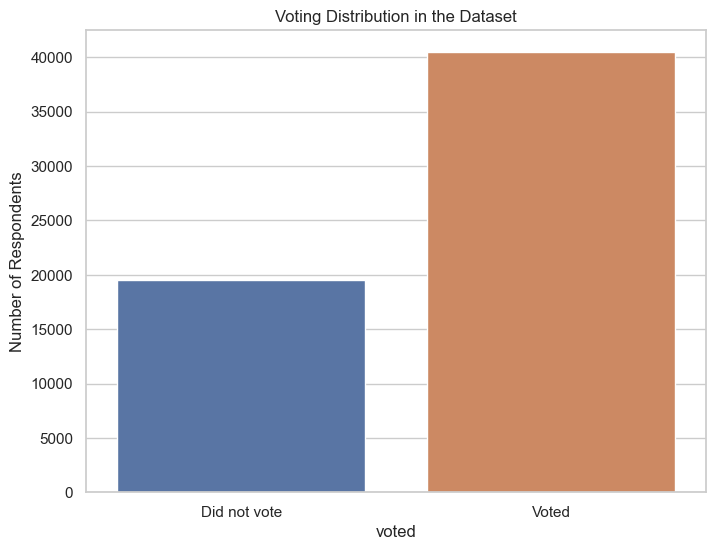

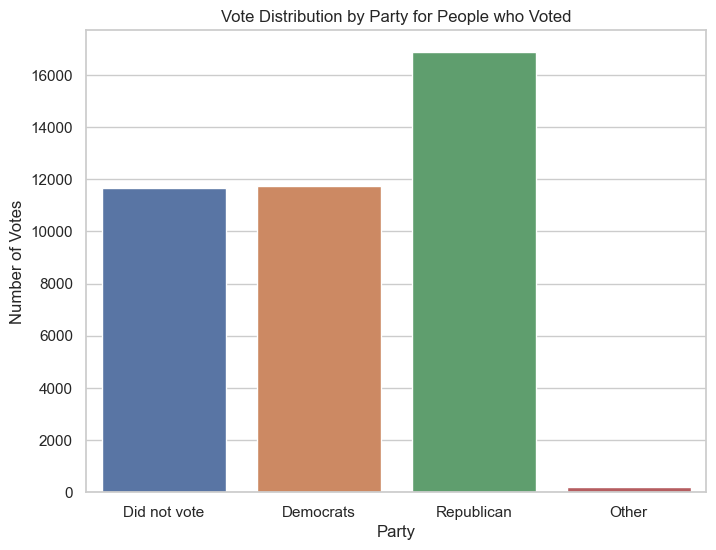

In [276]:
# Set the style for the plots
sns.set(style='whitegrid')

# Plot the distribution of how many people voted in the dataset
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df, x='voted')
ax.set_xticklabels(['Did not vote', 'Voted'])
ax.set_title('Voting Distribution in the Dataset')
ax.set_ylabel('Number of Respondents')
plt.show()

# Plot the distribution of people who voted for each party
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df[new_df['voted'] == 1], x='party_voted')
ax.set_xticklabels(['Did not vote', 'Democrats', 'Republican', 'Other'])
ax.set_title('Vote Distribution by Party for People who Voted')
ax.set_xlabel('Party')
ax.set_ylabel('Number of Votes')
plt.show()


In [277]:
# Function to extract the social and economic scores from the website
def extract_scores(candidate_website):
    # Request the candidate's website
    response = requests.get(candidate_website)
    
    # Parse the website's HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the "Click for details" hyperlink
    details_link = soup.find('a', href=re.compile(r'^https://www.OnTheIssues.org/VoteMatch/candidate_map.asp'))
    
    if details_link is None:
        return -1, -1
    
    # Follow the "Click for details" hyperlink
    url = details_link['href']
    response = requests.get(url)

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the social and economic scores in the HTML
    all_tr = soup.find_all("tr")

    # Extract the social and economic scores
    social_score = all_tr[5].find_all("td")[1].find("font").text.strip("%")
    economic_score = all_tr[6].find_all("td")[1].find("font").text.strip("%")

    return social_score, economic_score

#function that stores the scores in the dataframe
def store_scores(df):
    for i, row in df.iterrows():
        name = row['senator']
        if name == 'J.D. Vance':
            str = 'JD_Vance'
        elif name == 'Thomas McDermott Jr.':
            str = 'Thomas_McDermott'
        elif name == 'Todd C. Young':
            str = 'Todd_Young'
        elif name == "Joe O'Dea":
            str = 'Joe_O%60Dea'
        elif name == 'John Kennedy':
            str = 'John_Neely_Kennedy'
        elif name == 'Mark R. Holland':
            str = 'Mark_Holland'
        else:
            str = "_".join(name.split())
        
        url = "https://www.ontheissues.org/Senate/" + str + '.htm' 
        social_score, economic_score = extract_scores(url)
        df.at[i, 'social_score'] = social_score
        df.at[i, 'economic_score'] = economic_score

In [278]:
#create a dataframe to store candidate information
candidate_df = new_df[['senator_voted', 'state', 'party_voted']].groupby('senator_voted').first().reset_index()
candidate_df.columns = ['senator', 'state', 'party']

#import candidates endorsed by trump
trump_endorsement = pd.read_csv('trump_endorsement.csv', skiprows=1, header=None)
trump_endorsement.columns = ['endorsed_senator']

#create new column about trump endorsement
candidate_df['trump_endorsement'] = candidate_df['senator'].isin(trump_endorsement['endorsed_senator']).astype(int)

#create new columns the store the scores of each candidate
store_scores(candidate_df)

In [279]:
candidate_df

,senator,state,party,trump_endorsement,social_score,economic_score
0,Adam Laxalt,32,0,1,28,83
1,Alex Padilla,6,1,0,83,25
2,Blake Masters,4,0,1,25,80
3,Bob McDermott,15,0,0,30,63
4,Brian Bengs,46,1,0,43,30
...,...,...,...,...,...,...
69,Todd C. Young,18,0,0,35,85
70,Tommy Williams,49,2,0,-1,-1
71,Trudy Busch Valentine,29,1,0,53,15
72,Val Demings,12,1,0,83,15


In [281]:
# Select only the required columns for aggregation
agg_columns = candidate_df[['state', 'party', 'social_score', 'economic_score', 'trump_endorsement']]

# Convert 'social_score' and 'economic_score' to numeric data types
candidate_df['social_score'] = pd.to_numeric(candidate_df['social_score'], errors='coerce')
candidate_df['economic_score'] = pd.to_numeric(candidate_df['economic_score'], errors='coerce')

# Group by 'state' and 'party' and calculate the mean 'social_score', 'economic_score', and 'trump_endorsement' for each group
state_level_agg = candidate_df.groupby(['state', 'party']).agg({
    'social_score': 'mean',
    'economic_score': 'mean',
    'trump_endorsement': lambda x: x.astype(int).mean()
}).reset_index()

# Merge
merged_df = new_df.merge(state_level_agg, how='left', left_on=['state', 'party_voted'], right_on=['state', 'party'])

# Drop the 'party' column since it is not needed anymore
merged_df.drop('party', axis=1, inplace=True)

#filter out people who did not vote or their votes were not recorded
merged_df = merged_df[(merged_df['voted'] != 0) & (merged_df['senate_vote_choice'] != -1) & (merged_df['senator_voted'].notnull())]

# Display the updated dataframe
merged_df


,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_illegal,congress_abortion,age,pol_involve,attitude_towards_dem,attitude_towards_rep,abortion_ballot,social_score,economic_score,trump_endorsement
2,1983126197,1,1,John Fetterman,42,1,0.891555,0.774314,2,5,...,2,1,44,1,0.0,0.0,0,80.0,25.0,0.0
3,1979974411,1,1,Richard Blumenthal,9,1,1.103598,1.207156,3,6,...,2,1,31,1,1.5,NaN,0,65.0,15.0,0.0
5,1981687607,1,2,Don Bolduc,33,0,0.114487,0.098909,1,5,...,2,2,67,1,-2.0,NaN,0,33.0,73.0,1.0
6,1983125989,1,1,Raphael Warnock,13,1,0.899045,1.210827,2,2,...,2,2,54,1,1.0,NaN,0,68.0,15.0,0.0
8,1981900613,1,1,John Fetterman,42,1,0.900071,0.853897,2,5,...,2,1,75,1,-1.0,-1.0,0,80.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59983,2046109403,1,2,Ted Budd,37,0,1.504072,1.469039,2,2,...,1,1,29,1,NaN,0.0,0,20.0,90.0,1.0
59991,2046109215,1,1,Alex Padilla,6,1,1.058854,0.826751,2,6,...,1,1,35,1,0.0,NaN,1,83.0,25.0,0.0
59993,2046149923,1,1,Chuck Schumer,36,1,0.949129,0.814437,2,6,...,2,1,31,1,0.5,NaN,0,70.0,5.0,0.0
59998,2045338427,1,1,Chuck Schumer,36,1,1.167724,1.256827,1,6,...,2,1,32,1,2.0,NaN,0,70.0,5.0,0.0


In [282]:
#combine attitudes towards dem and attitudes towards rep
def combine_attitudes(row):
    attitudes = [row['attitude_towards_dem'], row['attitude_towards_rep']]
    valid_attitudes = [att for att in attitudes if pd.notnull(att)]
    return sum(valid_attitudes) / len(valid_attitudes) if valid_attitudes else None

merged_df['attitude_towards_current_senators'] = merged_df.apply(combine_attitudes, axis=1)
merged_df = merged_df.drop(columns=['attitude_towards_rep', 'attitude_towards_dem'])

In [283]:
#check for missing value
missing_values_count = merged_df.isnull().sum()
print(missing_values_count)

caseid                                0
voted                                 0
senate_vote_choice                    0
senator_voted                         0
state                                 0
party_voted                           0
commonweight                          0
commonpostweight                      0
gender                                0
educ                                  0
race                                  0
fam_income                            0
marstat                               0
urbancity                             0
region                                0
presvote20post                        0
presvote16post                        0
pew_bornagain                         0
pew_religimp                          0
pew_churatd                           0
pew_prayer                            0
religpew                              0
pol_ideo                              0
approval_biden                        0
know_senate                           0


In [284]:
#For remaining rows without attitudes_towards_current_senators values, fill them with mean
merged_df.fillna(merged_df.mean(), inplace=True)

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_960/1359032956.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_df.fillna(merged_df.mean(), inplace=True)


In [285]:
#check for missing value
missing_values_count = merged_df.isnull().sum()
print(missing_values_count)

caseid                               0
voted                                0
senate_vote_choice                   0
senator_voted                        0
state                                0
party_voted                          0
commonweight                         0
commonpostweight                     0
gender                               0
educ                                 0
race                                 0
fam_income                           0
marstat                              0
urbancity                            0
region                               0
presvote20post                       0
presvote16post                       0
pew_bornagain                        0
pew_religimp                         0
pew_churatd                          0
pew_prayer                           0
religpew                             0
pol_ideo                             0
approval_biden                       0
know_senate                          0
income_change            

In [288]:
# Prepare the feature set (X) and the treatment indicator (W)
X = merged_df.drop(columns=['abortion_ballot', 'party_voted', 'commonweight', 'commonpostweight', 'caseid', 'voted', 'state', 'senator_voted'])
W = merged_df['abortion_ballot']

# Estimate propensity scores using logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X, W)
merged_df['propensity_score'] = lr.predict_proba(X)[:, 1]

# Split treated and control observations
treated = merged_df[merged_df['abortion_ballot'] == 1]
control = merged_df[merged_df['abortion_ballot'] == 0]

# Match treated and control observations based on propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
indices = indices.reshape(-1)

# Create a matched dataset
matched_control = control.iloc[indices]
matched_treated = treated.reset_index(drop=True)

# Concatenate matched treated and control observations
matched_data = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)


/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [289]:
matched_data

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_illegal,congress_abortion,age,pol_involve,abortion_ballot,social_score,economic_score,trump_endorsement,attitude_towards_current_senators,propensity_score
0,1983126033,1,2,Mark Meuser,6,0,1.226313,0.997712,1,6,...,1,2,37,1,1,18.0,73.0,0.0,0.0,0.248710
1,1983202389,1,1,Alex Padilla,6,1,0.905339,0.710053,2,5,...,2,1,34,1,1,83.0,25.0,0.0,-0.5,0.816808
2,1982290075,1,1,Alex Padilla,6,1,0.671453,0.433286,1,1,...,2,1,66,1,1,83.0,25.0,0.0,2.0,0.757682
3,1981978265,1,2,Rand Paul,21,0,0.993021,0.850214,1,3,...,2,2,69,1,1,63.0,88.0,1.0,0.5,0.570049
4,1983209009,1,2,Mark Meuser,6,0,0.935423,0.806969,2,3,...,2,1,70,1,1,18.0,73.0,0.0,-2.0,0.520938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7791,2012372825,1,2,Jo Rae Perkins,41,0,0.690621,0.363426,2,5,...,2,2,58,1,0,5.0,93.0,0.0,-2.0,0.814755
7792,2015903407,1,1,Michael Bennet,8,1,0.662688,1.457148,2,2,...,2,2,69,1,0,75.0,20.0,0.0,2.0,0.273375
7793,2010491767,1,1,Brian Schatz,15,1,0.971224,2.259879,2,2,...,1,1,41,1,0,90.0,35.0,0.0,1.0,0.785617
7794,2011457953,1,1,Ron Wyden,41,1,1.393620,4.680972,2,2,...,2,1,40,1,0,80.0,13.0,0.0,1.5,0.779770


In [300]:
#assess the balance of covariates by calculating the standardized mean differences before and after matching
def calculate_smd(df, treatment_col, covariate_cols, treatment_value=1):
    treated = df[df[treatment_col] == treatment_value]
    control = df[df[treatment_col] != treatment_value]
    
    mean_treated = treated[covariate_cols].mean()
    mean_control = control[covariate_cols].mean()
    
    std_treated = treated[covariate_cols].std()
    std_control = control[covariate_cols].std()
    
    smd = (mean_treated - mean_control) / np.sqrt((std_treated**2 + std_control**2) / 2)
    
    return smd

# Calculate SMD before matching
covariate_columns = [x for x in merged_df.columns.to_list() if x not in ['abortion_ballot', 'party_voted', 'commonweight', 'commonpostweight', 'caseid', 'voted', 'state', 'senator_voted']]
smd_before = calculate_smd(merged_df, 'abortion_ballot', covariate_columns)
smd_before.name = 'SMD Before Matching'

# Calculate SMD after matching
smd_after = calculate_smd(matched_data, 'abortion_ballot', covariate_columns)
smd_after.name = 'SMD After Matching'

# Compare SMD before and after matching
smd_comparison = pd.concat([smd_before, smd_after], axis=1)
smd_comparison


,SMD Before Matching,SMD After Matching
senate_vote_choice,-0.176307,-0.260449
gender,-0.075433,-0.014531
educ,0.131661,0.163016
race,0.300738,-0.281967
fam_income,0.020576,-0.102330
marstat,0.099572,-0.071518
urbancity,-0.230291,-0.181266
region,1.546855,-0.093296
presvote20post,-0.052167,-0.329874
presvote16post,-0.014688,-0.224204


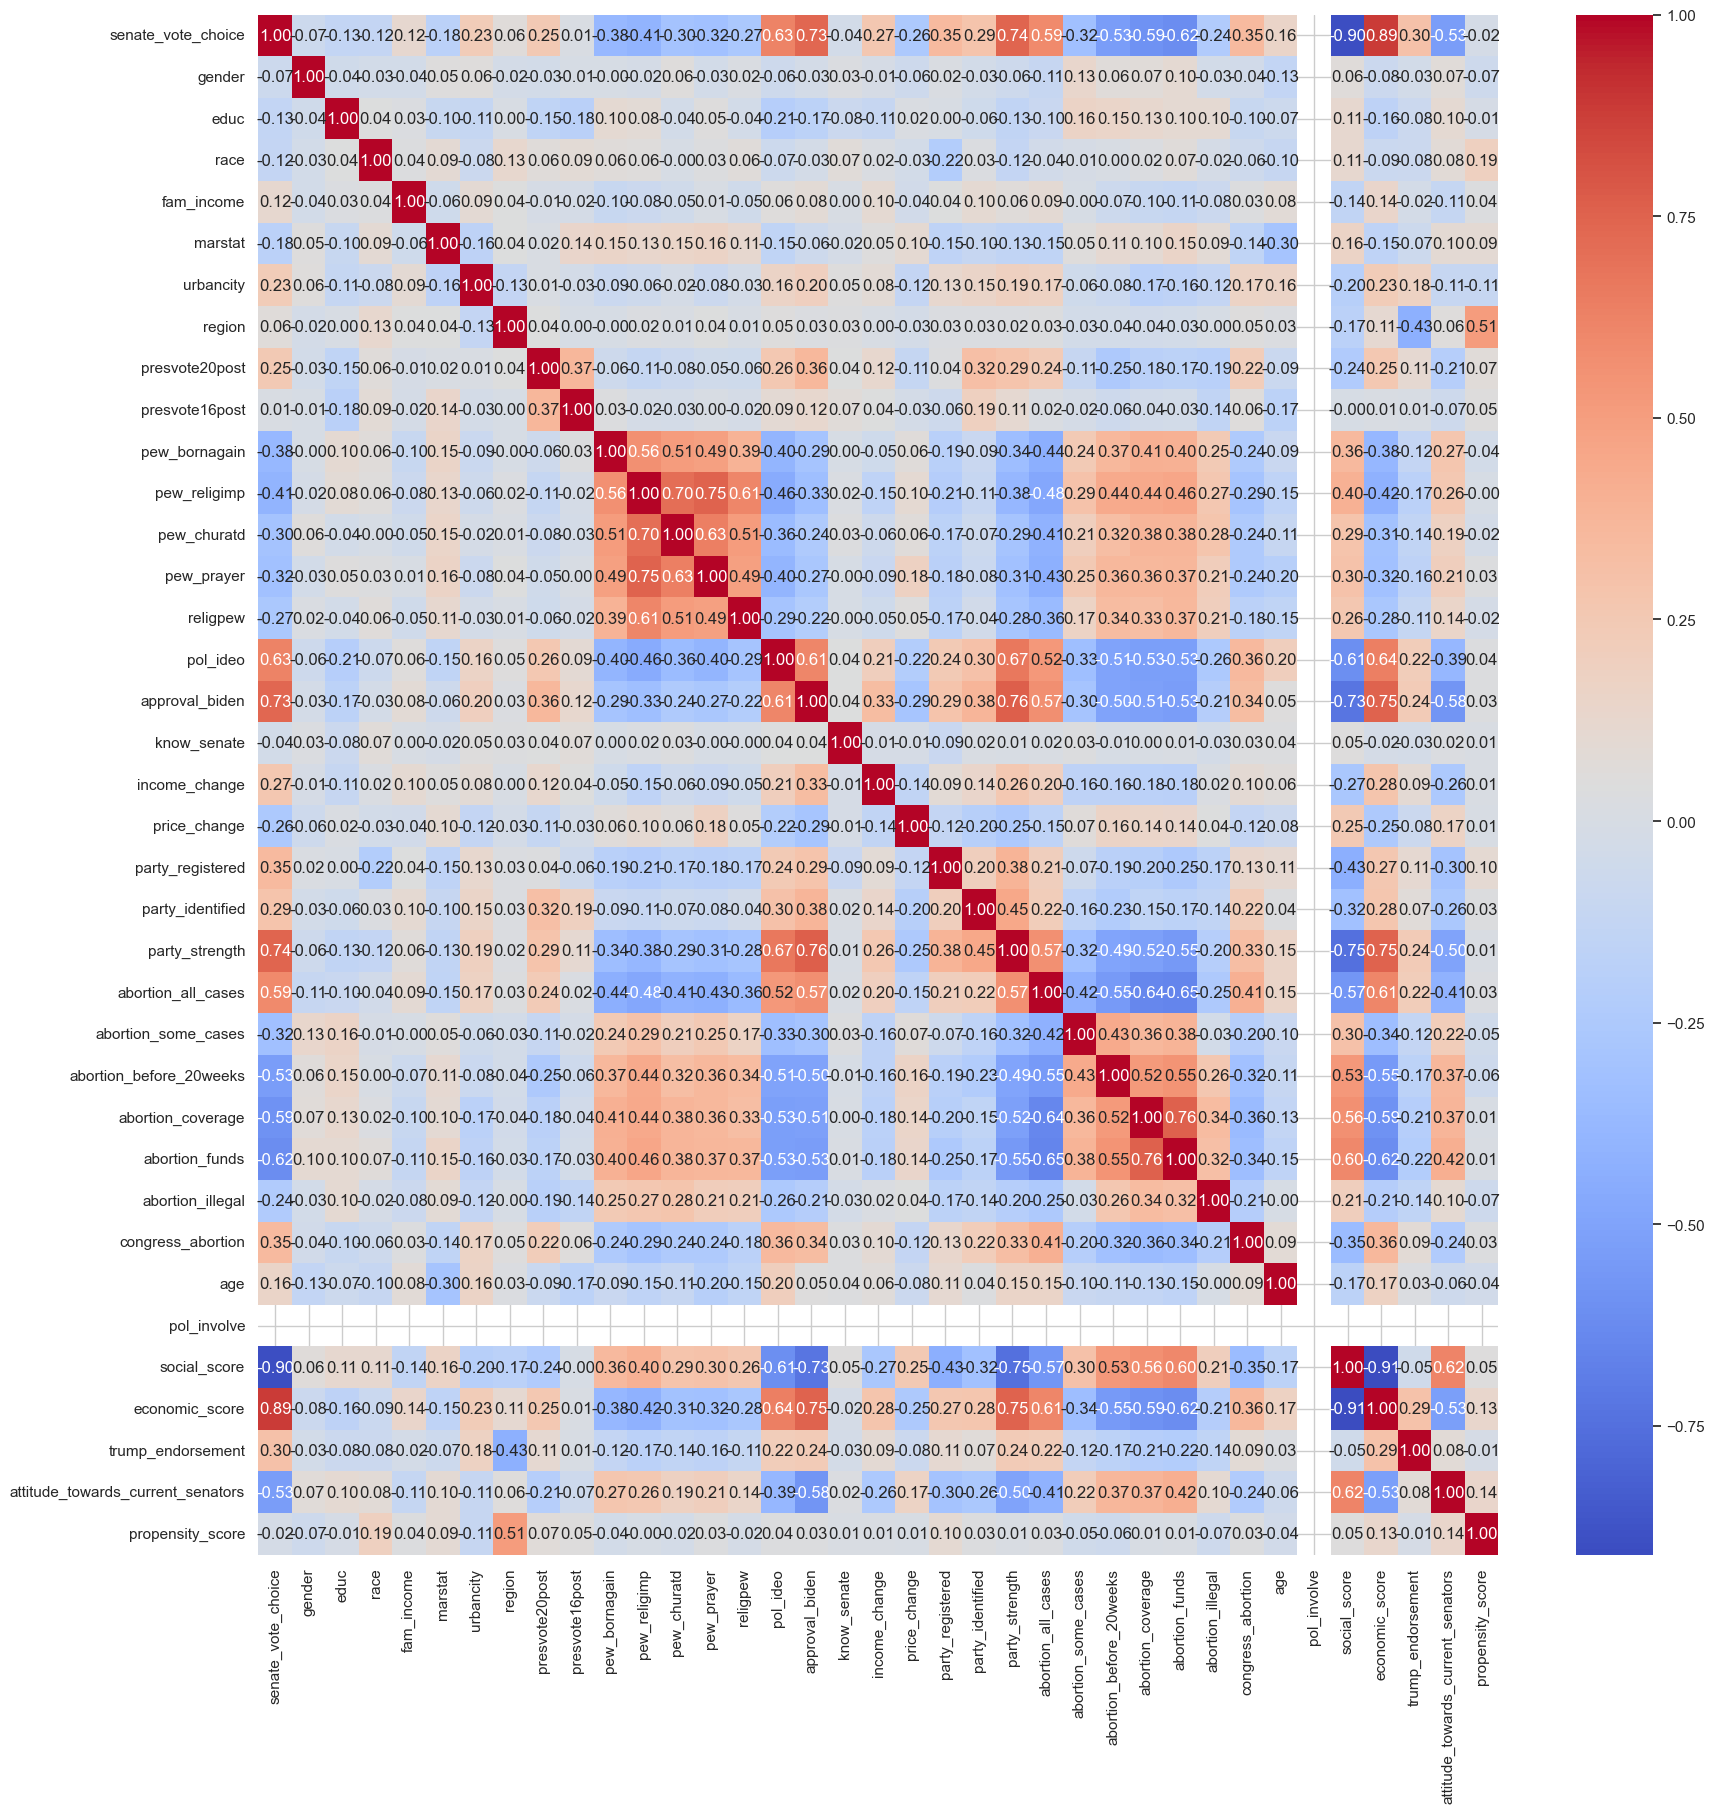

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt
correlations = matched_data[covariate_columns].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [298]:
matched_data

,caseid,voted,senate_vote_choice,senator_voted,state,party_voted,commonweight,commonpostweight,gender,educ,...,abortion_illegal,congress_abortion,age,pol_involve,abortion_ballot,social_score,economic_score,trump_endorsement,attitude_towards_current_senators,propensity_score
0,1983126033,1,2,Mark Meuser,6,0,1.226313,0.997712,1,6,...,1,2,37,1,1,18.0,73.0,0.0,0.0,0.248710
1,1983202389,1,1,Alex Padilla,6,1,0.905339,0.710053,2,5,...,2,1,34,1,1,83.0,25.0,0.0,-0.5,0.816808
2,1982290075,1,1,Alex Padilla,6,1,0.671453,0.433286,1,1,...,2,1,66,1,1,83.0,25.0,0.0,2.0,0.757682
3,1981978265,1,2,Rand Paul,21,0,0.993021,0.850214,1,3,...,2,2,69,1,1,63.0,88.0,1.0,0.5,0.570049
4,1983209009,1,2,Mark Meuser,6,0,0.935423,0.806969,2,3,...,2,1,70,1,1,18.0,73.0,0.0,-2.0,0.520938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7791,2012372825,1,2,Jo Rae Perkins,41,0,0.690621,0.363426,2,5,...,2,2,58,1,0,5.0,93.0,0.0,-2.0,0.814755
7792,2015903407,1,1,Michael Bennet,8,1,0.662688,1.457148,2,2,...,2,2,69,1,0,75.0,20.0,0.0,2.0,0.273375
7793,2010491767,1,1,Brian Schatz,15,1,0.971224,2.259879,2,2,...,1,1,41,1,0,90.0,35.0,0.0,1.0,0.785617
7794,2011457953,1,1,Ron Wyden,41,1,1.393620,4.680972,2,2,...,2,1,40,1,0,80.0,13.0,0.0,1.5,0.779770


In [299]:
import statsmodels.api as sm

# Replace 'abortion_ballot' with your treatment variable and 'party_voted' with your outcome variable
X = matched_data[['abortion_ballot']]
y = matched_data['party_voted']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Perform logistic regression
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

# Print the results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.669869
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            party_voted   No. Observations:                 7796
Model:                          Logit   Df Residuals:                     7794
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Apr 2023   Pseudo R-squ.:                0.009335
Time:                        10:58:04   Log-Likelihood:                -5222.3
converged:                       True   LL-Null:                       -5271.5
Covariance Type:            nonrobust   LLR p-value:                 3.387e-23
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1470      0.032      4.577      0.000       0.084       0.210
abortion_ballo

In [301]:
import statsmodels.api as sm

# Replace 'abortion_ballot' with your treatment variable and 'party_voted' with your outcome variable
X = matched_data[['abortion_ballot'] + covariate_columns]
y = matched_data['party_voted']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Perform logistic regression
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

# Print the results
print(logit_result.summary())

         Current function value: inf
         Iterations: 35


/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix